# Taller 1: Regresión lineal, Ridge y Lasso.
**Nombres:** 

*   Diryon Yonith Mora Romero.
*   Laura Valentina Gonzalez Rodriguez.

En este taller analizaremos métodos de regresión lineal para el conjunto de datos [Hitters](https://www.kaggle.com/datasets/floser/hitters). Cada registro corresponde a un jugador de baseball. Las variables son registros como cantidad de *home runs* o número de años en las ligas mayores. La variable objetivo es el salario de dicho jugador. 
Usaremos regresión de Ridge y Lasso y las compararemos. 

- El taller consiste en realizar todas las tareas señaladas con **TO_DO**. 

- Se puede realizar de forma individual o en parejas.

- Subir el cuaderno en dos formatos : 1. En formato .ipynb  2. En formato .html.
- Subirlo al aula a más tardar el miércoles 15 de ferbero.



In [24]:
#importar paquetes
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression 
import random

In [25]:
#Evitar la impresión de warnings
import warnings
warnings.filterwarnings("ignore")

En primer lugar, leemos el conjunto de datos e imprimimos la información sobre sus columnas.

In [26]:
df = pd.read_csv('Hitters.csv').dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      263 non-null    int64  
 1   Hits       263 non-null    int64  
 2   HmRun      263 non-null    int64  
 3   Runs       263 non-null    int64  
 4   RBI        263 non-null    int64  
 5   Walks      263 non-null    int64  
 6   Years      263 non-null    int64  
 7   CAtBat     263 non-null    int64  
 8   CHits      263 non-null    int64  
 9   CHmRun     263 non-null    int64  
 10  CRuns      263 non-null    int64  
 11  CRBI       263 non-null    int64  
 12  CWalks     263 non-null    int64  
 13  League     263 non-null    object 
 14  Division   263 non-null    object 
 15  PutOuts    263 non-null    int64  
 16  Assists    263 non-null    int64  
 17  Errors     263 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  263 non-null    object 
dtypes: float64

In [27]:
#TO_DO 1: Codificar las 3 variables categóricas como variables Dummy (usar por ejemplo el
#método get_dummies de Pandas). 

df = pd.get_dummies(df, columns=["League","Division","NewLeague"])

In [28]:
#Verificar la codificación anterior
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480.0,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500.0,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91.5,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750.0,1,0,0,1,1,0


In [29]:
# Definimos la columna y, correspondiente a la variable objetivo.
y = df.Salary

#TO_DO 2:
#Eliminar la columna con la variable dependiente (Salary) y de ser necesario, las columnas originales para las que se crearon
#variables dummy. Dar a la nueva tabla de atributos el nombre X (mayúscula).

X = df.drop(columns=["Salary"] + list(df.filter(regex="Division|League|New_League")))
#X = df.drop(columns=["Salary"])

#Verificar lo anterior
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263 entries, 1 to 321
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   AtBat    263 non-null    int64
 1   Hits     263 non-null    int64
 2   HmRun    263 non-null    int64
 3   Runs     263 non-null    int64
 4   RBI      263 non-null    int64
 5   Walks    263 non-null    int64
 6   Years    263 non-null    int64
 7   CAtBat   263 non-null    int64
 8   CHits    263 non-null    int64
 9   CHmRun   263 non-null    int64
 10  CRuns    263 non-null    int64
 11  CRBI     263 non-null    int64
 12  CWalks   263 non-null    int64
 13  PutOuts  263 non-null    int64
 14  Assists  263 non-null    int64
 15  Errors   263 non-null    int64
dtypes: int64(16)
memory usage: 34.9 KB


Vamos a generar valores de Lambda equidistantes para experimentar sobre un intervalo. Estos valores se encuentran entre 10^(-2) y 10^10. Experimentaremos con 100 valores distintos de lambda. Para esto usamos *linspace* de Numpy:

In [30]:
# Creamos una lista con posibles valores para el parámetro Lambda para los algoritmos Ridge y Lasso
lambdas = 10**np.linspace(10,-2,100)
lambdas

array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.84803587e+07, 2.15443469e+07, 1.62975083e+07,
       1.23284674e+07, 9.32603347e+06, 7.05480231e+06, 5.33669923e+06,
       4.03701726e+06, 3.05385551e+06, 2.31012970e+06, 1.74752840e+06,
       1.32194115e+06, 1.00000000e+06, 7.56463328e+05, 5.72236766e+05,
       4.32876128e+05, 3.27454916e+05, 2.47707636e+05, 1.87381742e+05,
       1.41747416e+05, 1.07226722e+05, 8.11130831e+04, 6.13590727e+04,
       4.64158883e+04, 3.51119173e+04, 2.65608778e+04, 2.00923300e+04,
       1.51991108e+04, 1.14975700e+04, 8.69749003e+03, 6.57933225e+03,
       4.97702356e+03, 3.76493581e+03, 2.84803587e+03, 2.15443469e+03,
      

Vamos a usar el algoritmo de Ridge de SKlearn para hacer regresión con los diferentes valores del parámetro Lambda, de manera que podamos realizar algunas observaciones y comparaciones.

In [31]:
# Aplicamos el algoritmo Ridge de SKlearn para los diferentes valores de Lambda definidos
# en la celda anterior. Guardar los vectores obtenidos de parámetros en la lista coefs.
ridge = Ridge(normalize = True)
coefs = []

for a in lambdas:
    ridge.set_params(alpha = a)
    ridge.fit(X, y)
    coefs.append(ridge.coef_)
#Imprimir las dimensiones de la matriz coef.   
np.shape(coefs)
#coefs

(100, 16)

Usamos los arreglos *lambdas* y *coefs* para comparar los resultados de la regresión Ridge para diferentes valores del parámetro Lambda.

Text(0, 0.5, 'weights')

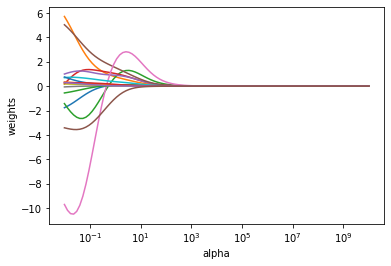

In [32]:
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

TO_DO 3: Hallar el coeficiente de las variables Hits Runs y Walks, arrojado por el algoritmo Ridge, para 3 lambdas distintos.
Ejemplo: "Para lambda=3.06795364e+00, el coeficiente de Hits es (valor), el coeficiente de Runs es (valor) y el coeficiente de Walks es (valor)."

**Respuesta:**

In [33]:
new_lambdas = [random.random() * 10 for _ in range(3)]
columns = ["Hits", "Runs", "Walks"]
for a in new_lambdas:
    ridge.set_params(alpha = a)
    text = f"Para lambda = {a}, "
    for column in columns:
        ridge.fit(X[[column]], y)
        text += f"el coeficiente de {column} es {ridge.coef_[0]}."
    print(text)

Para lambda = 7.24247657376263, el coeficiente de Hits es 0.5320535724296219.el coeficiente de Runs es 0.899742724813562.el coeficiente de Walks es 1.1185753676904917.
Para lambda = 2.7332871906284426, el coeficiente de Hits es 1.174685708012636.el coeficiente de Runs es 1.986482141075451.el coeficiente de Walks es 2.4696281837949843.
Para lambda = 5.86234443399111, el coeficiente de Hits es 0.6390584367953862.el coeficiente de Runs es 1.080696022040964.el coeficiente de Walks es 1.34353956623168.


A continuación separamos el conjunto de datos en conjunto de Entrenamiento y Testeo.

In [34]:
#TO_DO 4: 
#Escoger random_sate = 0. Y partir el conjunto de datos en Entrenamiento y Testeo, con porcentaje de Testeo de 20%

X_train, X_test, y_train, y_test = train_test_split( X, y,test_size=0.20, random_state = 0)

Apliquemos el algoritmo de regresión lineal de SKLearn a éste conjunto de datos.

In [35]:
#TO_DO 5: Aplicar el algoritmo de regresión lineal de SKLearn a éste conjunto de datos e
# imprimir su coeficiente de determinación R^2 (score)

regr = LinearRegression()
regr.fit(X_train, y_train)
print("Score = ", regr.score(X_test, y_test))

Score =  0.5479922558493867


TO_DO 6: Cuáles son los valores de los parámetros en el modelo lineal obtenido? (Pista: En el taller anterior eran la pendiente y el punto de corte.) Cuál valor corresponde con cuál variable en el Dataset?

**Respuesta:**

In [36]:
print("Variable  \t  Slope \n", pd.Series(regr.coef_, index = X.columns)) 
print('\n Intercept:', regr.intercept_)

Variable  	  Slope 
 AtBat     -2.015452
Hits       7.520141
HmRun      9.312551
Runs      -1.719625
RBI       -2.340944
Walks      7.285795
Years      7.682881
CAtBat    -0.165969
CHits      0.274872
CHmRun    -0.531528
CRuns      1.164023
CRBI       0.653199
CWalks    -0.828976
PutOuts    0.198798
Assists    0.452282
Errors    -5.308274
dtype: float64

 Intercept: 76.70365473102424


## Regresión Ridge
Ahora apliquemos Regresión de Ridge para algunos valores de lambda. En primer lugar usemos Lambda=4. 

In [37]:
#Modelo de regresión de Ridge para Lambda=4
# Note el uso del parámetro normalize=True
ridge = Ridge(alpha = 4, normalize = True)
ridge.fit(X_train, y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print("Variable  \t  Slope \n", pd.Series(ridge.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print("\n MSE = ", mean_squared_error(y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print("\n Score = ", ridge.score(X_test, y_test))         #Imprimir el coeficiente de determinación R^2

Variable  	  Slope 
 AtBat      0.110594
Hits       0.468121
HmRun      1.326256
Runs       0.780493
RBI        0.641412
Walks      0.975142
Years      2.797871
CAtBat     0.008290
CHits      0.032614
CHmRun     0.217398
CRuns      0.065236
CRBI       0.065205
CWalks     0.060786
PutOuts    0.048521
Assists    0.023617
Errors    -0.394895
dtype: float64

 MSE =  182118.17271549694

 Score =  0.3807122688711331


In [38]:
#TO_DO 7 Hacer regresión Ridge para lambda=10^10. Imprimir los coeficientes obtenidos y el error MSE
# Usar el parámetro normalize=True

ridge = Ridge(alpha = 10**10, normalize = True)
ridge.fit(X_train, y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print("Variable  \t  Slope \n", pd.Series(ridge.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print("\n MSE = ", mean_squared_error(y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print("\n Score = ", ridge.score(X_test, y_test))         #Imprimir el coeficiente de determinación R^2

Variable  	  Slope 
 AtBat      1.199328e-10
Hits       4.318179e-10
HmRun      1.650614e-09
Runs       7.511952e-10
RBI        7.227535e-10
Walks      8.969918e-10
Years      3.478858e-09
CAtBat     9.426433e-12
CHits      3.471758e-11
CHmRun     2.742106e-10
CRuns      6.998938e-11
CRBI       7.355186e-11
CWalks     7.564463e-11
PutOuts    3.687963e-11
Assists    2.030162e-11
Errors    -3.698884e-13
dtype: float64

 MSE =  297431.06357839174

 Score =  -0.011405977691507418


TO_DO 8: Cuál debería ser el coeficiente de determinación R^2 al asignar Lambda=0? Justifique y compruebe en la siguiente celda.

**Respuesta y justificación:**

La penalización impuesta a los coeficientes del modelo en la regresión de Ridge se controla mediante el valor de lambda. Un valor grande de lambda normalmente reduce los coeficientes y aumenta la penalización, lo que disminuye la complejidad del modelo y ayuda a evitar el sobreajuste. En cambio, un valor bajo de lambda reduce la penalización y permite que los coeficientes del modelo sean mayores. 

En el caso de lambda = 10^10, el valor es tan grande que reduce los coeficientes a tal punto que son 0 e incluso negativos, produciendo un coeficiente de determinación R-square negativo cuando teóricamente no debería ocurrir. Esto último se justifica en la gran penalización aplicada a los coeficientes de la regresión, produciendo un modelo subajustado que es incapaz de modelar nuevos datos con precisión.

De lo anterior podremos inferir que, al considerar un lambda cercano a 0, la penalización será casi nula. El modelo se ajustará a los datos de entrenamiento sin restricciones, produciendo en el caso de los datos de entrenamiento una predicción relativamente buena, pero inexacto para datos nuevos.

In [39]:
# TO_DO 9 Verifique su respuesta anterior.
# Usar el parámetro normalize=True

ridge = Ridge(alpha = 0, normalize = True)
ridge.fit(X_train, y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print(pd.Series(ridge.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print(mean_squared_error(y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print(ridge.score(X_test, y_test))         #Imprimir el coeficiente de determinación R^2

AtBat     -2.015452
Hits       7.520141
HmRun      9.312551
Runs      -1.719625
RBI       -2.340944
Walks      7.285795
Years      7.682881
CAtBat    -0.165969
CHits      0.274872
CHmRun    -0.531528
CRuns      1.164023
CRBI       0.653199
CWalks    -0.828976
PutOuts    0.198798
Assists    0.452282
Errors    -5.308274
dtype: float64
132925.00445295323
0.5479922558493846


In [40]:
# con RidgeCV de SKLearn hacer cross validation con la lista de Lambdas y normalize True
# Imprimir el alpha optimo. Note que usamos el parametro normalize=True
ridgecv = RidgeCV(alphas = lambdas, normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.017475284000076828

In [41]:
#TO_DO 10 Con el alpha optimo hallado arriba, calcular los coeficientes(parámetros),
# el error cuadrático MSE y el coeficiente de determinación R^2 en el conjunto de Testeo.
# Usar el parámetro normalize=True

ridge = Ridge(alpha = ridgecv.alpha_, normalize = True)
ridge.fit(X_train, y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print(pd.Series(ridge.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print("MSE = ", mean_squared_error(y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print("Score = ",ridge.score(X_test, y_test))         #Imprimir el coeficiente de determinación R^2

AtBat     -1.360775
Hits       4.688444
HmRun      4.268878
Runs       0.779590
RBI       -0.500785
Walks      5.491605
Years     -0.403531
CAtBat    -0.026945
CHits      0.192030
CHmRun     0.032421
CRuns      0.488181
CRBI       0.287817
CWalks    -0.541507
PutOuts    0.191367
Assists    0.334572
Errors    -5.791659
dtype: float64
MSE =  138610.546698774
Score =  0.5286587291334531


## Regresión Lasso
Ahora aplicaremos regresión Lasso a éste conjunto de datos. Para esto, en primero lugar encontremos el valor óptimo de Lambda.

In [42]:
# TO_DO 11 Determinar el valor óptimo de Lambda mediante corss-validation
## Usar el parámetro normalize=True

lassocv = LassoCV(normalize = True)
lassocv.fit(X, y)
print("El mejor valor de Lambda es:", lassocv.alpha_)

El mejor valor de Lambda es: 0.1369103948595804


In [43]:
# TO_DO 12 Aplicar regresión de Lasso al conjunto de datos, usando el valor de Lambda encontrado arriba
# Usar el parámetro normalize=True

lasso = Lasso(alpha = lassocv.alpha_, normalize = True)
lasso.fit(X_train, y_train)             # Entrenar una regresión de Ridge para el conjunto de entrenamiento.
pred = ridge.predict(X_test)           # Uso del modelo para predecir el conjunto de Testeo
print(pd.Series(lasso.coef_, index = X.columns)) # Imprimir los coeficientes del modelo
print("MSE = ", mean_squared_error(y_test, pred))          # Imprimit el error de mínimos cuadrados MSE
print("Score = ",lasso.score(X_test, y_test))         #Imprimir el coeficiente de determinación R^2

AtBat     -1.791097
Hits       6.153781
HmRun      3.465932
Runs       0.000000
RBI       -0.000000
Walks      5.995228
Years     -0.000000
CAtBat    -0.000000
CHits      0.000000
CHmRun     0.000000
CRuns      0.768853
CRBI       0.279342
CWalks    -0.656026
PutOuts    0.193751
Assists    0.299230
Errors    -4.599111
dtype: float64
MSE =  138610.546698774
Score =  0.5401480453819162


In [44]:
#Imprimir los coeficientes de la misma forma que en Ridge.
pd.Series(lasso.coef_, index=X.columns)

AtBat     -1.791097
Hits       6.153781
HmRun      3.465932
Runs       0.000000
RBI       -0.000000
Walks      5.995228
Years     -0.000000
CAtBat    -0.000000
CHits      0.000000
CHmRun     0.000000
CRuns      0.768853
CRBI       0.279342
CWalks    -0.656026
PutOuts    0.193751
Assists    0.299230
Errors    -4.599111
dtype: float64

In [45]:
#Imprimir el score (R^2)
print("Score = ",lassocv.score(X_test, y_test))

Score =  0.6077404787012837


TO_DO 13: Escriba sus conclusiones acerca de los diferentes modelos obtenidos y sus métricas.

In [46]:
print("\t \t Datos Resultantes")
print("\t Modelo de Ridge \n", "Alpha = ", ridgecv.alpha_, "\n MSE = ", mean_squared_error(y_test, pred), "\n Score = ", ridge.score(X_test, y_test))
print("\t Modelo de Lasso \n", "Alpha = ", lassocv.alpha_, "\n MSE = ", mean_squared_error(y_test, pred), "\n Score = ", lassocv.score(X_test, y_test))

	 	 Datos Resultantes
	 Modelo de Ridge 
 Alpha =  0.017475284000076828 
 MSE =  138610.546698774 
 Score =  0.5286587291334531
	 Modelo de Lasso 
 Alpha =  0.1369103948595804 
 MSE =  138610.546698774 
 Score =  0.6077404787012837



**Conclusión**

Los métodos de regresión como los modelos de regresión Lasso y Ridge se emplean para mejorar el rendimiento de la regresión lineal y evitar el sobreajuste. La principal diferencia entre los dos modelos es que Ridge emplea una penalización de valor cuadrático, mientras que Lasso aplica una penalización de valor absoluto a los coeficientes de regresión. Esto puede resultar en diferentes conjuntos de coeficientes para los dos métodos.

En cuanto a las datos obtenidos, el coeficiente de determinación R^2 indica la varianza de la variable de respuesta que se puede explicar por el modelo de regresión. Un valor de R^2 más alto significa que el modelo puede explicar una mayor parte de la variabilidad de los datos de respuesta. Dado que el método Lasso es algo menor en este caso que el método Ridge, Ridge explica ligeramente más la variación en los datos que Lasso.

Al comparar los dos algoritmos, Lasso tiene un valor alfa más bajo que Ridge, lo que indica que utiliza una colección más pequeña de características para producir su predicción. Esto concuerda con la hipótesis de que, mientras que Ridge sólo reduce el tamaño de las características sin importancia, Lasso tiende a llevar sus coeficientes a cero.

Adicionalmente, para calcular el valor ideal de alfa en modelos de regresión Ridge y Lasso, el procedimiento de validación cruzada es una herramienta potente. Podemos identificar el valor de alfa que maximiza la capacidad del modelo para generalizar los nuevos datos, al probar distintos valores de alfa. Esto es crucial para garantizar que nuestro modelo tiene un gran poder de predicción y no está sobreajustado.

En términos de lo bien que pueden predecir nuevos valores y ajustarse a los datos, estos modelos son generalmente comparables. Sin embargo, Lasso podría ser una opción preferible si desea favorecer la simplicidad del modelo y minimizar el número de características incluidas en la predicción. Ridge podría ser una opción mejor si desea maximizar la cantidad de variabilidad de los datos que se explica.